In [1]:

!git clone https://www.github.com/yl7344/Multiclass-classification
%cd Multiclass-classification
!ls

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,ConcatDataset

import torchvision.models as model
import data
import ResNet

Cloning into 'Multiclass-classification'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 82 (delta 33), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (82/82), done.
/content/Multiclass-classification
CNN.py	 evaluate.py  pdf	 ResNet1.py  train.py
data.py  notebooks    README.md  ResNet.py



Extracting ./Cifar100/cifar-100-python.tar.gz to ./Cifar100


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def knn(train_data, nth_data, k):
    data_num = train_data.shape[0]
    distance = np.zeros((data_num,))    
    Knn = np.zeros((k,))    
    for i in range(data_num):
        sub = train_data[i] - train_data[nth_data]
        distance[i] = (sub**2).sum()
            
    for i in range(k):
        temp = float("inf")
        temp_j = 0
        for j in range(distance.shape[0]):
            if (j != nth_data) and (distance[j] < temp):
                temp = distance[j]
                temp_j = j
        distance[temp_j] = float("inf")
        Knn[i] = temp_j
    return Knn   
            
def knn1(train_data, test_data, k):
    data_num = train_data.shape[0]
    distance =np.zeros((data_num,))
    Knn = np.zeros((k,))
    for i in range(data_num):
        sub = train_data[i] - test_data
        distance[i] = (sub**2).sum()
    
    for i in range(k):
        temp = float("inf")
        temp_j = 0
        for j in range(distance.shape[0]):
            if distance[j] < temp:
                temp = distance[j]
                temp_j = j
        distance[temp_j] = float("inf")
        Knn[i] = temp_j
    return Knn

In [14]:



#import sampleProcess as sp
#from sklearn.model_selection import KFold

 
#Structure of ML_KNN  
#reference: https://github.com/hinanmu/MLKNN/blob/master/mlknn.py  
class ML_KNN(object):
    s = 1
    k = 10
    labels_num = 0
    train_data_num = 0
    train_data = np.array([])
    train_target = np.array([])
    #test_data = np.array([])
    #test_target = np.array([])
    rtl = np.array([])    
    Ph1 = np.array([])
    Ph0 = np.array([])
    Peh1 = np.array([])
    Peh0 = np.array([])
    predict_labels = np.array([])
    def __init__(self, _train_data, _train_target, _k):
        self.train_data = _train_data
        self.train_target = _train_target
        self.k = _k
        self.labels_num = 100
        self.train_data_num = 250 #self.train_data.size()
        self.Ph1 = np.zeros(20)
        self.Ph0 = np.zeros((20,))
        self.Peh1 = np.zeros((20, self.k + 1))
        self.Peh0 = np.zeros((20, self.k + 1))
    
    def fit(self):
        for i in range(self.labels_num):
            y = 0
            for j in range(self.train_data_num):
              print(self.train_target)
              if self.train_target[i] == 1:
                    y = y + 1
            self.Ph1[i] = (self.s + y)/(self.s*2 + self.train_data_num)
        self.Ph0 = 1 - self.Ph1
                   
        for i in range(self.labels_num):
            c1 = np.zeros((self.k + 1,))
            c0 = np.zeros((self.k + 1,))
            for j in range(self.train_data_num):
                temp = 0
                KNN = knn(self.train_data, j, self.k)
                for k in range(self.k):
                    if self.train_target[int(KNN[k])][i].item() == 1:
                        temp = temp + 1
                if self.train_target[j][i].item() == 1:
                    c1[temp] = c1[temp] + 1
                else:
                    c0[temp] = c0[temp] + 1
            
            for l in range(self.k + 1):
                self.Peh1[i][l] = (self.s + c1[l])/(self.s*(self.k + 1) + c1.sum())
                self.Peh0[i][l] = (self.s + c0[l])/(self.s*(self.k + 1) + c0.sum())
                
            
    def predict(self, _test_data):
        self.rtl = np.zeros((_test_data.shape[0], self.labels_num))
        test_data_num = _test_data.shape[0]
        self.predict_labels = np.zeros((test_data_num, self.labels_num))
        for i in range(test_data_num):
            KNN = knn1(self.train_data, _test_data[i], self.k)
            for j in range(self.labels_num):
                temp = 0
                y1 = 0
                y0 = 0
                for k in range(self.k):
                    if self.train_target[int(KNN[k])][j].item() == 1:
                        temp = temp + 1
                y1 = self.Ph1[j]*self.Peh1[j][temp]
                y0 = self.Ph0[j]*self.Peh0[j][temp]
                self.rtl[i][j] = self.Ph1[j]*self.Peh1[j][temp]/(self.Ph1[j]*self.Peh1[j][temp] + self.Ph0[j]*self.Peh0[j][temp])
                if y1 > y0:
                    self.predict_labels[i][j] = 1 
                else:
                    self.predict_labels[i][j] = 0
        #print(self.predict_labels)
        return self.predict_labels

In [5]:
def evaluate(model,dataloader):
  acc = 0.0
  rights = 0
  wrongs = 0
  for i, test_examples in enumerate(dataloader, 0):
    #predicting using the nets
    inputs, labels = test_examples
    predicted_outputs = model(inputs.to(device))
    #Selecting the label which has the largest outputs
    outputs = torch.argmax(predicted_outputs, 1)

    #Counting successfully and unsuccessfully predicted cases
    for j, n in enumerate(outputs):
      if n == labels[j]:
        rights += 1
      else:
        wrongs += 1
  #calculate accuracy with the cases we recorded
  acc = rights/(rights+wrongs)
  #return the accuracy
  return acc


In [6]:
def train_knn(nets,train,test,loss_fn,optimizer,max_iter,watch_iter,number):
    total_iter = 0
    loss = 0.0
    train_loss_his = [[] for i in range(numbers)]
    test_loss_his = [[] for i in range(numbers)]
    #nets = [ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],100).to(device) for i in range(numbers)]
    total_train_loss = []
    total_test_loss = []
    while total_iter < max_iter:
        for batch in train:
            total_iter += 1
            train_inputs, train_labels = batch
            
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
            mlKnn = ML_KNN(train_inputs, train_labels, 10)
            print(train_inputs.shape)
            for i in range(list(train_labels.size())[0]):
              superclass = int(train_labels[i].item()/20)
              #print(superclass)
              #optimizer = 
              model = nets[superclass]
              train_outputs = model(train_inputs)
              l = loss_fn(train_outputs, train_labels)
              loss += l.item()
              optimizer[superclass].zero_grad()
              l.backward()
              optimizer[superclass].step()
              train_loss_his[super_label].append(l.item())
            mlKnn.fit()
            if total_iter % watch_iter == 0:
                train_loss = loss / watch_iter
                total_train_loss.append(train_loss)
                loss = 0.0
                for batch in test:
                    test_inputs, test_labels = batch
                    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                    super_label = mlKnn.predict(test_inputs)
                    for i in range(list(test_labels.size())[0]):
                      super_label = int(mlKnn.predict(test_inputs[i]))
                      #optimizer = optimizer[super_label]
                      model = nets[super_label]
                      test_outputs = model(test_inputs)
              
                      l = loss_fn(test_outputs, test_labels)
                      loss += l.item()
                      test_loss_his[super_label].append(l.item())
                txt = f'iter: {total_iter: 6d}, train loss: {train_loss}, test_loss: {loss}'
                print(txt)
                print('accuracy: ' + str(evaluate(model,test)*100) + '%')
                total_test_loss.append(loss)
                loss = 0.0
    return train_loss_his,test_loss_his,total_train_loss,total_test_loss

In [7]:

def train_KNN_Net(total_iter, epochs, numbers ):
    # [3, 4, 6, 3] basic block size, with up to 128 chanels.
    #nets = [ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],100).to(device) for i in range(numbers)]
    nets = [model.resnet34().to(device) for i in range(numbers)]
    # Load Whole Dataset
    trainDataLoader, testDataLoader =  data.loadData(250)

    loss = nn.CrossEntropyLoss()
    optimizer = [torch.optim.Adam(nets[i].parameters(), lr=0.0001)  for i in range(numbers)]

    

    train_loss_his,test_loss_his,total_train_loss,total_test_loss = train_knn(nets,trainDataLoader,testDataLoader,loss,optimizer,total_iter,epochs,numbers)
    
    return nets, train_loss_his,test_loss_his,total_train_loss,total_test_loss
    

In [27]:
nets, train_loss_his, test_loss_his,total_train_loss,total_test_loss = train_KNN_Net(10000,1000,20)


iter: 1000, train loss: 2.0099417344331743, test_loss: 85.5653406381607
accuracy: 53.71%
iter: 2000, train loss: 2.0073717209100725, test_loss: 66.79577219486237
accuracy: 56.58%
iter: 3000, train loss: 1.5816031076908112, test_loss: 64.698903799057
accuracy: 58.989999999999995%
iter: 4000, train loss: 1.2862259700298309, test_loss: 64.73621165752411
accuracy: 56.32%
iter: 5000, train loss: 1.0585972194075584, test_loss: 62.18414103984833
accuracy: 59.00000000000004%
iter: 6000, train loss: 0.8850931547284127, test_loss: 63.65067279338837
accuracy: 58.91%
iter: 7000, train loss: 0.7258984387516976, test_loss: 61.16033983230591
accuracy: 60.32%
iter: 8000, train loss: 0.6007833771705627, test_loss: 60.88087272644043
accuracy: 62.26%
iter: 9000, train loss: 0.4886865997612476, test_loss: 58.13920617103577
accuracy: 63.57%
iter: 10000, train loss: 0.38782855884730816, test_loss: 57.65500807762146
accuracy: 65.04%


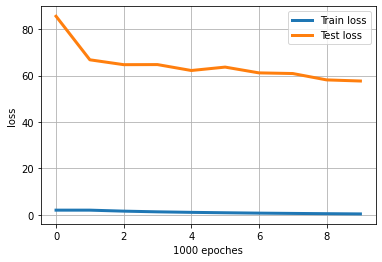

In [21]:
plt.plot(range(len(total_train_loss)),total_train_loss,'-',linewidth=3,label='Train loss')
plt.plot(range(len(total_test_loss)),total_test_loss,'-',linewidth=3,label='Test loss')
plt.xlabel('1000 epoches')
plt.ylabel('loss')
plt.grid(True)
plt.legend()